# Machine Learning Project: Argument Detection (evidence-claim)
#### Athens University of Economics and Business
#### MSc in Business Analytics
#### Machine Learning & Content Analytics  
#### Team Members: 
         Mikes Manos  (f2821908)           

         Nikolopoulos Filippos  (f2821909)

         Panagiotatos Konstantinos (f2821911)

## Importing libraries

In [1]:
from __future__ import print_function
import numpy as np
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint
from tensorflow import keras

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

import re
import os
from glob import glob
from typing import Tuple, List
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from ipywidgets import interact
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import bert
from itertools import cycle
from typing import List, Tuple
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp

np.random.seed(1228)  # for reproducibility

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, Concatenate, Bidirectional, concatenate, GlobalMaxPool1D, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from transformers import *

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

## Running the functions we are going to use in the next steps 

In [2]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

In [3]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [4]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.6)
    plt.ylim(0.4, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

## Importing the Dataset

In [5]:
#inserting the dataset
class ArgumentParser:

    @staticmethod
    def get_argument_files():
        return list(Path('argument').glob('**/*.csv'))

    def setup_without_context(self):
        files = self.get_argument_files()
        frames = list()

        for file_path in tqdm(files):
          df = pd.read_csv(file_path)
          try:

            df['label'] = df['label'].str.strip()
            df['label'].replace('_', 'NO LABEL', inplace=True)
            df['label'].replace('Missing', 'NO LABEL', inplace=True)
            df['label'] = df['label'].str.strip().str.upper()
            df['document']=str(file_path).split('\\')[-1]

            frames.append(df)
          except:
            print(df.head())
            print(file_path)
            next()

        data = pd.concat(frames).reset_index(drop=True)
        return {'X': data['sentence'].tolist(),
                'y': data['label'].tolist(),
                'df': data}


if __name__ == "__main__":
    parser = ArgumentParser()

    swc_doc = parser.setup_without_context()
    pprint(swc_doc['X'][:5])
    pprint(swc_doc['y'][:5])

100%|██████████| 889/889 [00:05<00:00, 169.10it/s]


['Multivariate Granger causality between CO2 emissions, energy consumption, '
 'FDI (foreign direct investment) and GDP (gross domestic product): Evidence '
 'from a panel of BRIC (Brazil, Russian Federation, India, and China) '
 'countries',
 'Abstract:',
 'This paper addresses the impact of both economic growth and financial '
 'development on environmental degradation using a panel cointegration '
 'technique for the period between 1980 and 2007, except for Russia '
 '(1992–2007).',
 'In long-run equilibrium, CO2 emissions appear to be energy consumption '
 'elastic and FDI inelastic, and the results seem to support the Environmental '
 'Kuznets Curve (EKC) hypothesis.',
 'The causality results indicate that there exists strong bidirectional '
 'causality between emissions and FDI and unidirectional strong causality '
 'running from output to FDI.']
['NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE']


In [6]:
# Getting a glimpse at some random rows of the dataset
df=swc_doc['df']
df.sample(10)

,label,sentence,document
10081,NO LABEL,n.).,NRT_G7B2_S1055790315001827.csv
171,NO LABEL,"However, there is little data on its health ef...",ABC_G1B1_10.1016_j.envres.2020.109851.csv
6017,NO LABEL,"Background: In 2014, United Nations member sta...",FOP_G3B3_PMID32046109.csv
7161,NO LABEL,The aim of this study is to investigate the ri...,GOQ_G6B2_PMID_30475818.csv
2325,NO LABEL,"Only sex predicted means for all four traits, ...",DEK_G2B2_27.csv
4078,NO LABEL,"A large-scale sample size of more than 46,000 ...",EIK_G4B3_CorpusID_208358160.csv
9175,NO LABEL,Many policies indirectly address climate varia...,LNR_G5B2_10.7892_BORIS.69298.csv
6489,NO LABEL,Title: Evaluation of a school-based health pro...,GHO_G3B4_CorpusID24228496.csv
10862,NO LABEL,Abstract: This exploratory mixed-methods study...,RST_G7B4_S0959378012001288.csv
2553,NO LABEL,Such a pattern is evident in the tracking of g...,DIJ_G2B2_23.csv


In [7]:
df.dtypes

label       object
sentence    object
document    object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     11064 non-null  object
 1   sentence  11064 non-null  object
 2   document  11064 non-null  object
dtypes: object(3)
memory usage: 259.4+ KB


## Unique labels 

In [9]:
df.label.unique()

array(['NO LABEL', 'EVIDENCE', 'CLAIM'], dtype=object)

## Checking for missing values

In [10]:
# Checking for missing values
df.isna().sum()

label       0
sentence    0
document    0
dtype: int64

## Number of labels occurences

In [11]:
#getting a sense of the relative numbers of the labels
df.drop(['sentence'],1).groupby(['label']).count()

,document
label,
CLAIM,990
EVIDENCE,1486
NO LABEL,8588


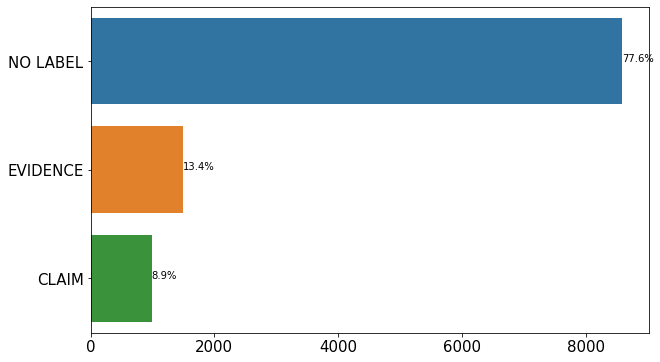

In [12]:
# ploting the cumulative counts of the three labels together with their respective percentages
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(y="label", data=df)
total = len(df)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

## Data preprocessing

In [13]:
# Cleaning the text from unnecessary values and stopwords
df = swc_doc['df'].reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['sentence'] = df['sentence'].apply(clean_text)
df.sample(10)

,label,sentence,document
1519,EVIDENCE,cases rotterdam project buyzet logistics hub h...,ABC_G1B3_10.1016_j.trpro.2019.06.045.csv
1947,NO LABEL,abstract,DEJ_G2B1_47.csv
976,NO LABEL,categorizing publications based innovation dri...,ABC_G1B2_10.1016_j.technovation.2018.02.015.csv
10750,NO LABEL,captured individuals field measured body tempe...,RST_G7B4_S0306456514000084.csv
5982,NO LABEL,abstract,FOP_G3B3_PMID30893248.csv
429,NO LABEL,india one order improve economy help make indi...,ABC_G1B1_Corpus ID 190457136.csv
1035,EVIDENCE,2 provinces facing ecological overload excludi...,ABC_G1B3_10.1016_j.ecolind.2019.106035.csv
1651,NO LABEL,women value midwifery continuity care model sy...,DEI_G2B1_6.csv
10039,NO LABEL,promote progress toward climate responsive des...,NRT_G7B1_S0360132312003022.csv
840,NO LABEL,analysis shows clear differences groups low hi...,ABC_G1B2_10.1016_j.renene.2018.08.069.csv


### Splitting the dataset into Train and Test dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size=0.20, random_state=10, stratify=df['label'])
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8851,) (8851,)
(2213,) (2213,)


In [15]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

8851 train sequences
2213 test sequences


In [16]:
X_train

5516     sdm log baht increase gdp per capita equivalen...
10053    extreme flooding events create number implicat...
3711     mean ages circumcised non circumcised 25 9 5 9...
9328     efficient endogenous switching regression mode...
1166                                              abstract
                               ...                        
2052     findings also show constitutive forces discour...
517      abundant supply biomass tropical environmental...
5918     objective research advance evaluation monetiza...
2089     conclusion lovi concise coherent validated ind...
9973     abstract reflectance measurements acquired spa...
Name: sentence, Length: 8851, dtype: object

In [17]:
y_train

5516     NO LABEL
10053       CLAIM
3711     NO LABEL
9328     NO LABEL
1166     NO LABEL
           ...   
2052     NO LABEL
517      EVIDENCE
5918     NO LABEL
2089        CLAIM
9973     NO LABEL
Name: label, Length: 8851, dtype: object

## Neural Network models

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 15_000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 50

In [19]:
# Using Tokenizer for X train dataset
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11710 unique tokens.


In [20]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train)
print(X_test)

[[2035, 2491, 7267, 87, 489, 61, 490, 1804, 201, 489, 61, 490, 18, 121, 469, 7268, 751, 523, 96, 72, 2321, 541, 129, 328, 121, 847, 1702], [453, 1532, 557, 1333, 179, 308, 966, 1132, 228, 680, 1086], [235, 1533, 1267, 110, 1267, 421, 135, 26, 135, 454, 129, 52, 26, 23, 278], [1268, 3859, 3860, 212, 48, 5501, 41, 367, 55, 4, 11, 118, 634, 726, 133, 2036, 819], [20], [168, 9, 2492, 928, 397, 820, 156, 263, 164, 70, 28, 295, 2714, 1459, 56], [9, 174, 1176, 1334, 21, 2715, 354, 194, 1391, 56, 344, 727, 1, 13, 5502, 5503, 1608, 1913, 2174, 3007, 125, 1914, 2175, 848, 1269, 1270, 681, 4514], [1335, 184, 228, 7269, 3404, 355, 3861, 309, 1271, 1703, 3, 1220], [652, 776, 129, 3008, 1805, 7270, 136, 142], [142, 2176, 455, 1133, 145, 653, 1336, 635, 636, 821], [1915, 151, 3862, 16, 217, 106, 1534, 3405, 93, 193, 2177, 7, 456, 6, 1806, 107, 61, 752], [3009, 3406, 18, 33, 5504], [1609, 24, 1337, 398, 1807, 2716, 7271, 381, 3010, 3407, 1704, 3863, 337, 7272, 1705, 1460], [37], [344, 406, 8, 24, 363,

In [21]:
# Padding X dataset (Train and Test)
print("Pad sequences (samples x time)")
X_train_padded = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
X_test_padded = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print(X_train_padded.shape,y_train.shape)
print(X_test_padded.shape,y_test.shape)

Pad sequences (samples x time)
(8851, 40) (8851,)
(2213, 40) (2213,)


In [22]:
#Importing the One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
y_enc= OneHotEncoder(sparse=False)

In [23]:
# Encoding Y train dataset
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [24]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [25]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (8851, 3)
y_test shape: (2213, 3)


In [26]:
# Checking padded X train dataset
X_train_padded[:10]

array([[2035, 2491, 7267,   87,  489,   61,  490, 1804,  201,  489,   61,
         490,   18,  121,  469, 7268,  751,  523,   96,   72, 2321,  541,
         129,  328,  121,  847, 1702,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 453, 1532,  557, 1333,  179,  308,  966, 1132,  228,  680, 1086,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 235, 1533, 1267,  110, 1267,  421,  135,   26,  135,  454,  129,
          52,   26,   23,  278,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [1268, 3859, 3860,  212,   48, 5501,   41,  367,   55,    4,   11,
         118,  634,  726,  133, 2036,  819,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

### Creating class weights based on the size of each class

In [27]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train_enc, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
final_class_weights = dict(enumerate(class_weights))

C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# LSTM - RNN

In [28]:
##################   Rnn Bidirectional #############################
#Setting the hyperparameters
max_len = MAX_SEQUENCE_LENGTH  # cut texts after this number of words (among top max_features most common words)
batch_size = 200
emb_dim = 256
max_feats = 14_000 # total vocabulary size
dropout_rate=0.5
hidden_dims = 128
n_outputs=3

In [29]:
rnn_model_Bid=Sequential()

# this is the placeholder tensor for the input sequences
rnn_model_Bid.add(Input(shape=(max_len,), dtype='int32'))

# this embedding layer will transform the sequences of integers into 
# vectors of size 100
rnn_model_Bid.add(Embedding(max_feats, emb_dim, input_length=max_len))

rnn_model_Bid.add(Bidirectional(LSTM(128, dropout=dropout_rate,recurrent_dropout=dropout_rate, return_sequences=True)))

rnn_model_Bid.add(Flatten())

rnn_model_Bid.add(Dense(hidden_dims, activation='relu'))

rnn_model_Bid.add(Dense(hidden_dims))
#rnn_model_Bid.add(Activation('softmax'))
rnn_model_Bid.add(Dropout(dropout_rate))
rnn_model_Bid.add(Activation('relu'))

# since we have a binary classification scheme, we selece ONE neuron with SIGMOID activation.
rnn_model_Bid.add(Dense(3))
rnn_model_Bid.add(Activation('softmax'))



In [30]:
# Initialize optimizer
opt = keras.optimizers.Adam(lr=0.0005)

rnn_model_Bid.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(rnn_model_Bid.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 256)           3584000   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 256)           394240    
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1310848   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0

In [31]:
print('Train...')

history2=rnn_model_Bid.fit(
    X_train_padded,
    y_train_enc,
    batch_size=batch_size,
    verbose=2,
    epochs=15,
    validation_split=0.10, # Splitting into 90% train and 10% validation
    class_weight=final_class_weights,
    callbacks=[ModelCheckpoint(filepath='rnn_model_Bid.h3',mode='max',monitor='val_accuracy',verbose=2,save_best_only=True)]
)

Train...
Epoch 1/15

Epoch 00001: val_accuracy improved from -inf to 0.59707, saving model to rnn_model_Bid.h3
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rnn_model_Bid.h3\assets
40/40 - 60s - loss: 1.0641 - accuracy: 0.5146 - val_loss: 0.9171 - val_accuracy: 0.5971
Epoch 2/15

Epoch 00002: val_accuracy improved from 0.59707 to 0.60497, saving model to rnn_model_Bid.h3
INFO:tensorflow:Assets written to: rnn_model_Bid.h3\assets
40/40 - 62s - loss: 0.8792 - accuracy: 0.6702 - val_loss: 0.8650 - val_accuracy: 0.6050
Epoch 3/15

Epoch 00003: val_accuracy improved from 0.60497 to 0.68623, saving model to rnn_model_Bid.h3
INFO:tensorflow:Assets written to: rnn_model_Bid.h3\assets
40/40 - 72s - loss: 0.5799 - accuracy: 0.7954 - val_loss: 0.7896 - val_accuracy: 0.6862
Epoch 4/15

Epoch 00004: val_accuracy improved from 0.68623 to 0.70880, saving model to rnn_model_Bid.h3
INFO:tensorflow:Assets written to: rnn_model_Bid.h3\

In [32]:
rnn_model_Bid_final = keras.models.load_model('rnn_model_Bid.h3')

In [33]:
# saving the model to json format
open('model_rnn.json', 'w').write(rnn_model_Bid_final.to_json())
# saving the weights of the model separately
rnn_model_Bid_final.save_weights('weights.h3')

In [34]:
score = rnn_model_Bid_final.evaluate(
    X_test_padded,  # features
    y_test_enc,  # labels
    batch_size=batch_size,  # batch size
    verbose=2  # the most extended verbose
)

print('\nTest crossentropy:', score[0])
print('\nTest accuracy:', score[1])

12/12 - 4s - loss: 1.5072 - accuracy: 0.7519

Test crossentropy: 1.5072418451309204

Test accuracy: 0.7519204616546631


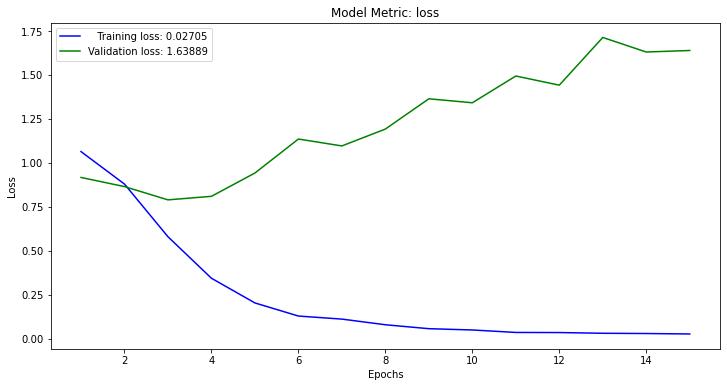

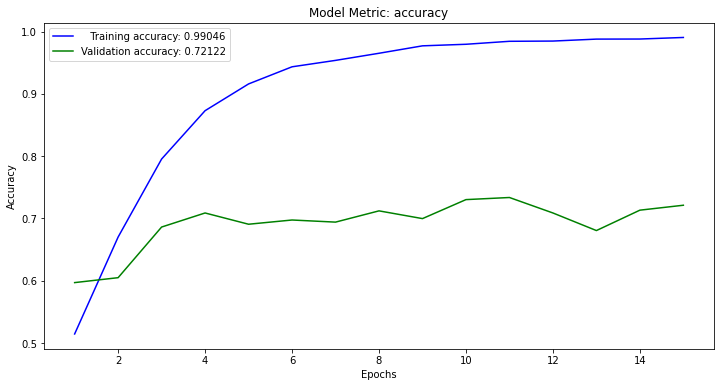

In [35]:
plot_keras_history(history2)

In [36]:
# Use to yield probability distribution over the categories
y_test_pred_probs = rnn_model_Bid_final.predict(X_test_padded)
y_test_pred_probs

array([[8.7628639e-01, 2.9520520e-03, 1.2076153e-01],
       [1.0268687e-03, 1.1397064e-04, 9.9885917e-01],
       [2.1737177e-09, 6.4836456e-09, 1.0000000e+00],
       ...,
       [5.6580973e-11, 2.1341821e-11, 1.0000000e+00],
       [1.2704586e-05, 1.2445723e-05, 9.9997485e-01],
       [4.2475639e-03, 2.8526220e-02, 9.6722621e-01]], dtype=float32)

In [37]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

y_test_preds = np.argmax(rnn_model_Bid_final.predict(X_test_padded), axis=-1)

y_test_preds[:50]

array([0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2], dtype=int64)

In [38]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [39]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_labels = y_enc.inverse_transform(y_test_pred).flatten()
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_labels)
# a bit prettier
pd.DataFrame(conf_mat,
             columns = y_enc.categories_,
             index=y_enc.categories_)

,CLAIM,EVIDENCE,NO LABEL
CLAIM,69,23,106
EVIDENCE,24,98,175
NO LABEL,84,137,1497


In [40]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_labels))

              precision    recall  f1-score   support

       CLAIM       0.39      0.35      0.37       198
    EVIDENCE       0.38      0.33      0.35       297
    NO LABEL       0.84      0.87      0.86      1718

    accuracy                           0.75      2213
   macro avg       0.54      0.52      0.53      2213
weighted avg       0.74      0.75      0.75      2213



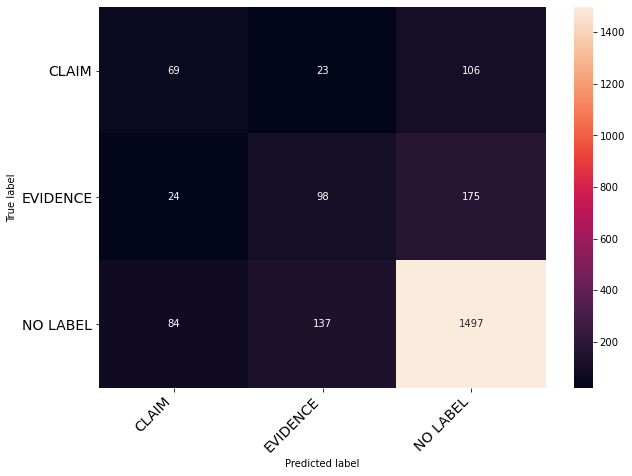

,CLAIM,EVIDENCE,NO LABEL
CLAIM,69,23,106
EVIDENCE,24,98,175
NO LABEL,84,137,1497


In [41]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=y_test_pred_labels,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


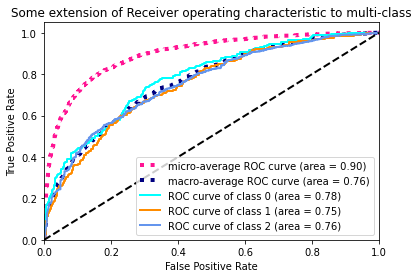

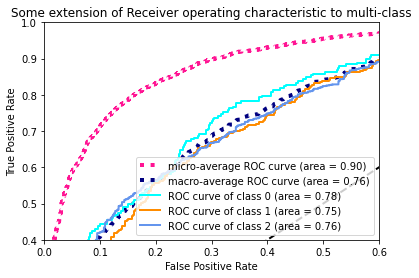

In [42]:
# ROC curve
y_score = rnn_model_Bid_final.predict(X_test_padded)

plot_multi_class_roc_auc_curves(nb_classes=3,
                                y_true=y_test_enc,
                                y_pred_score=y_score)

In [43]:
import pandas as pd
import glob

path = r'C:\Users\konst\Desktop\MSc\3rd Semester\Machine Learning and Content Analytics\dataset\argument_test_set' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_test = pd.read_csv(filename,  index_col=None,header=None)
    li.append(df_test)

df_test = pd.concat(li, axis=0, ignore_index=True)

In [44]:
df_test

,0
0,Exploration and corrective measures of greenho...
1,Abstract:
2,Greenhouse gas emission is increasing alarming...
3,While researchers are struggling to minimize t...
4,This paper presents mathematical model of para...
...,...
1239,An LCA comparison of beef systems that differ ...
1240,"To enhance future food supply, grassland less ..."
1241,"Furthermore, studies included in our review di..."
1242,We concluded that beef production from dual-pu...


In [45]:
df_test.columns = ['sentence']

In [46]:
# Cleaning the text from unnecessary values and stopwords
#df = swc_doc['df'].reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_test['sentence'] = df_test['sentence'].apply(clean_text)
df_test.sample(10)

,sentence
800,compared survivors cancers survivors hnc almos...
342,women exposed physical psychological psycholog...
788,however reclassification raises awareness mate...
456,objectives fly fly fifo work involves commutin...
634,materials methods analysis representative data...
1228,abstract livestock production especially beef ...
618,women hba1c levels 48 mml mol scored higher su...
767,decrease observed genders causes deaths except...
1040,abstract designing fire management regulations...
28,rainy season relative clean fuels odds sufferi...


In [47]:
X_Final_Test=tokenizer.texts_to_sequences(df_test['sentence'])

In [48]:
X_Final_Test_padded = sequence.pad_sequences(X_Final_Test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

In [49]:
# Use to yield probability distribution over the categories
y_Final_test_pred_probs = rnn_model_Bid_final.predict(X_Final_Test_padded)
y_Final_test_pred_probs

array([[4.0742193e-06, 1.6019638e-06, 9.9999428e-01],
       [2.5992711e-06, 7.7670563e-07, 9.9999666e-01],
       [8.4791407e-07, 1.3101945e-05, 9.9998605e-01],
       ...,
       [1.1834957e-06, 2.6536405e-02, 9.7346240e-01],
       [2.9259110e-05, 5.9132231e-04, 9.9937940e-01],
       [5.1565002e-07, 3.8339081e-07, 9.9999905e-01]], dtype=float32)

In [50]:
y_Final_test_preds = np.argmax(rnn_model_Bid_final.predict(X_Final_Test_padded), axis=-1)

y_Final_test_preds[:50]

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       1, 2, 1, 1, 2, 2], dtype=int64)

In [51]:
# custom prediction function
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

y_Final_test_preds = get_one_hot_predictions(y_Final_test_pred_probs)
y_Final_test_preds

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [52]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_labels = y_enc.inverse_transform(y_Final_test_preds).flatten()

In [53]:
y_test_pred_labels[:50]

array(['NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'EVIDENCE', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'CLAIM', 'NO LABEL',
       'NO LABEL', 'EVIDENCE', 'CLAIM', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE', 'EVIDENCE',
       'EVIDENCE', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'CLAIM',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE', 'EVIDENCE',
       'NO LABEL', 'EVIDENCE', 'EVIDENCE', 'NO LABEL', 'NO LABEL'],
      dtype=object)

In [54]:
labels=pd.DataFrame(y_test_pred_labels)

In [55]:
labels

,0
0,NO LABEL
1,NO LABEL
2,NO LABEL
3,NO LABEL
4,NO LABEL
...,...
1239,NO LABEL
1240,NO LABEL
1241,NO LABEL
1242,NO LABEL


In [56]:
Final_Test= pd.concat([df_test['sentence'],labels],axis=1)

In [57]:
Final_Test.columns = ['sentence','label']

In [58]:
Final_Test

,sentence,label
0,exploration corrective measures greenhouse gas...,NO LABEL
1,abstract,NO LABEL
2,greenhouse gas emission increasing alarmingly ...,NO LABEL
3,researchers struggling minimize emission using...,NO LABEL
4,paper presents mathematical model parameters r...,NO LABEL
...,...,...
1239,lca comparison beef systems differ type diet h...,NO LABEL
1240,enhance future food supply grassland less suit...,NO LABEL
1241,furthermore studies included review include re...,NO LABEL
1242,concluded beef production dual purpose cows da...,NO LABEL


In [59]:
Final_Test.to_csv(r'Final_Test_lstm.csv')